# Pruebas AA/B

En el presente caso se va a realizar una prueba AA/B similar a aquella requerida en el proyecto 2 de analisis de datos. Para esto se tomaron en consideracion los mismos datos del archivo logs_exp_us.csv que contiene las siguientes columnas:

- EventName: Nombre del evento
- DeviceIDHash: Identificador del usuario univoco
- EventTimestamp: Fecha y hora del evento
- Expid:Numero de experimento 246 y 247 son los grupos de control y 248 es el grupo de prueba

Al igual que en el proyecto , seplantea un experimento en el cual la empresa deproductos alimenticios realiza un cambio en las fuentes de la aplicacion, y usted debe evaluar si dicho cambio afectara a los niveles de conversion en diferentes momentos de la navegacion de usuarios. Para esto, los datos se encuentran divididos en 3 grupos, lo cuales  2 son de control (A1 y A2) y uno de prueba (B).

Visto lo anterior usted debe

1. Realizar un diagnostico inicial de los datos y definir una estrategia de procesamiento acorde.
2. Realizar el debido procesamiento de los datos.
3. Realizar un analisis exploratorio de los datos.
4. Ejecutar la pruebas estadisticas que le permitan validar la hipostesis asociada al impacto que tendria el experimento.

In [ ]:
#Impotar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [1]:
#Carga de datos
data = pd.read_csv('https://raw.githubusercontent.com/jsaraujott/datos/refs/heads/main/logs_exp_us.csv', sep='\t')

NameError: name 'pd' is not defined

# Diagnostico inicial de los datos

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
data.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
50925,MainScreenAppear,6953415790057009349,1564739723,248
90714,CartScreenAppear,9070105870042240910,1564835003,247
6353,MainScreenAppear,3179569210883065573,1564639596,248
96494,PaymentScreenSuccessful,197027893265565660,1564844042,246
157302,MainScreenAppear,6520920615385872661,1565008964,248
135591,MainScreenAppear,2702313608280400792,1564941208,246
216921,MainScreenAppear,1941104928179008131,1565158405,248
203854,MainScreenAppear,3371952072282142471,1565109378,247
201109,MainScreenAppear,8836933201165064417,1565105795,248
157183,PaymentScreenSuccessful,4257848154605915902,1565008729,247


In [ ]:
data['EventName'].value_counts()

EventName
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64

In [ ]:
#visalizacion de usuarios
len(data['DeviceIDHash'].unique())

7551

In [ ]:
data['ExpId'].value_counts()

ExpId
248    85747
246    80304
247    78075
Name: count, dtype: int64

## Plan de accion de procesamiento de los datos

* Cambiar los nombres de las columnas a un formato snake_case.
* Convertir la columna EventTimestamp a tipo datetime.
* Extraer los componentes relevantes de las fechas que salgan del timestamp. Dia y la hora.
* Poner de una forma mas semantica a los grupos del experimento (A1, A2 y B).
* Eliminar los registros del tutorial.

**PLAN DE ACCION RESPECTO A OTRAS ACCIONES POSTERIORES**

* Analisis exploratorio de los datos
    *Resumen estadistico de los principales indicadores del caso
    * Estudiar la evolucion de los eventos por dia
    * Comportamiento de los eventos por hora
    * estuciar el balance de los grupos experimentales

* Analisis inferencia (Prueba AA/B)
    * Estudiar si existen diferencias  significativas de conversion entre los grupos

* Preparar el reporte final


**PROCESAMIENTO DE LOS DATOS**


Ajustar nombre de columnas


In [ ]:
data = data.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user', 'EventTimestamp':'timestamp', 'ExpId': 'exp_id'})

data.head ()

,event,user,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Ajustar el tipo de timestamp**

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='s')

data.sample(10)

,event,user,timestamp,exp_id
60041,MainScreenAppear,3894219336678663559,2019-08-02 14:11:02,247
230614,OffersScreenAppear,2431455045762717569,2019-08-07 14:06:19,247
93525,MainScreenAppear,7712419871006855851,2019-08-03 13:43:22,247
104827,OffersScreenAppear,3746015443593251752,2019-08-03 18:58:22,247
124142,MainScreenAppear,7939747556084232140,2019-08-04 12:41:18,247
237640,PaymentScreenSuccessful,3157218280152762199,2019-08-07 16:52:18,247
233728,CartScreenAppear,6567588976245816164,2019-08-07 15:18:51,247
132392,OffersScreenAppear,8005753485514903385,2019-08-04 16:24:13,247
49845,MainScreenAppear,8529102644019234716,2019-08-02 09:26:32,248
188100,MainScreenAppear,6571482566359906964,2019-08-06 09:39:39,248


**Extraer el dia del timestamp**

In [ ]:
data['timestamp'].describe()

count                           244126
mean     2019-08-04 10:18:35.842716160
min                2019-07-25 04:43:36
25%      2019-08-02 14:36:20.249999872
50%                2019-08-04 11:49:55
75%                2019-08-06 06:55:11
max                2019-08-07 21:15:17
Name: timestamp, dtype: object

In [ ]:
data['date'] = data['timestamp'].dt.floor('d')  # floor para redondear a la fecha mas cercana
data.sample(10)

,event,user,timestamp,exp_id,date
136273,OffersScreenAppear,6560178062388764565,2019-08-04 18:15:24,246,2019-08-04
31468,MainScreenAppear,6664988900969927561,2019-08-01 17:25:53,246,2019-08-01
76517,OffersScreenAppear,308940995223272529,2019-08-03 05:05:11,248,2019-08-03
54529,CartScreenAppear,4623191541214045580,2019-08-02 11:38:33,247,2019-08-02
24379,OffersScreenAppear,8581162121865650933,2019-08-01 14:36:08,248,2019-08-01
125991,OffersScreenAppear,3998117183680723225,2019-08-04 13:28:54,248,2019-08-04
119413,PaymentScreenSuccessful,3416523485693578105,2019-08-04 10:44:01,248,2019-08-04
86961,OffersScreenAppear,5556707202539887138,2019-08-03 11:00:58,247,2019-08-03
14451,CartScreenAppear,6672921039703653653,2019-08-01 10:32:34,247,2019-08-01
196701,OffersScreenAppear,6633275515297644052,2019-08-06 13:57:38,246,2019-08-06


**Extraer la hora del timestamp**

In [ ]:
data['hour'] = data['timestamp'].dt.hour
data.sample(10)

,event,user,timestamp,exp_id,date,hour
5152,MainScreenAppear,8470940792016881889,2019-08-01 05:04:41,247,2019-08-01,5
40772,OffersScreenAppear,5462686011002931011,2019-08-02 02:36:35,247,2019-08-02,2
84706,MainScreenAppear,1501908752948001879,2019-08-03 09:55:03,246,2019-08-03,9
3102,MainScreenAppear,3875442471617517817,2019-08-01 01:23:49,248,2019-08-01,1
151646,PaymentScreenSuccessful,1100007125648169445,2019-08-05 10:06:06,248,2019-08-05,10
72506,MainScreenAppear,4903282557313240250,2019-08-02 20:17:21,247,2019-08-02,20
205851,CartScreenAppear,8942553003070671545,2019-08-06 17:25:14,247,2019-08-06,17
139755,MainScreenAppear,5470324789239987013,2019-08-04 20:56:23,248,2019-08-04,20
65147,MainScreenAppear,8685495455749621832,2019-08-02 16:15:07,247,2019-08-02,16
176843,MainScreenAppear,4946524891244986315,2019-08-05 22:44:21,248,2019-08-05,22


**Cambiar semantica de exp_id**

In [ ]:
def exp_sem (x):
    if x == 246:
        return 'A1'
    elif x == 247:
        return 'A2'
    else:
        return 'B'
    
data['group'] = data['exp_id'].apply(exp_sem)
data.sample(10)

,event,user,timestamp,exp_id,date,hour,group
210643,CartScreenAppear,1989685320445148348,2019-08-06 19:43:50,247,2019-08-06,19,A2
45099,CartScreenAppear,7483596365340385091,2019-08-02 06:54:35,248,2019-08-02,6,B
210683,MainScreenAppear,1683981161505856484,2019-08-06 19:45:04,248,2019-08-06,19,B
110159,MainScreenAppear,5353434405992767128,2019-08-04 05:25:44,248,2019-08-04,5,B
157076,OffersScreenAppear,7572795345577928939,2019-08-05 12:36:37,247,2019-08-05,12,A2
136968,MainScreenAppear,4045960531434778873,2019-08-04 18:36:43,247,2019-08-04,18,A2
26788,MainScreenAppear,6705876350616553983,2019-08-01 15:37:36,248,2019-08-01,15,B
188847,MainScreenAppear,5577907597733399014,2019-08-06 10:00:55,248,2019-08-06,10,B
58617,MainScreenAppear,5287660122200561379,2019-08-02 13:34:23,247,2019-08-02,13,A2
48527,OffersScreenAppear,1878105091481906390,2019-08-02 08:48:32,246,2019-08-02,8,A1


**Eliminar los registros del tutorial**

In [ ]:
data = data.query('event != "Tutorial"')
data.shape

(243074, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243074 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243074 non-null  object        
 1   user       243074 non-null  int64         
 2   timestamp  243074 non-null  datetime64[ns]
 3   exp_id     243074 non-null  int64         
 4   date       243074 non-null  datetime64[ns]
 5   hour       243074 non-null  int32         
 6   group      243074 non-null  object        
dtypes: datetime64[ns](2), int32(1), int64(2), object(2)
memory usage: 13.9+ MB


# Analisis exploratorio de los datos

**Resumen de los principales indicadores**

In [ ]:
#Grandes numero
events = len(data)
days = len(data['date'].unique())
users = len(data['user'].unique())
events_per_user = events / users
events_per_day = events / days

print('KPI SUMMARY')
print('============')
print(f'{events:,} events')
print(f'{days} days')
print(f'{users:,} users')
print(f'{events_per_user:.2f} events per user')
print(f'{events_per_day:.2f} events per day')



KPI SUMMARY
243,074 events
14 days
7,547 users
32.21 events per user
17362.43 events per day


In [ ]:
#Tasas de conversión
funnel =(
    data
    .pivot_table(index= 'event', values='user', aggfunc='nunique')
    .sort_values('user', ascending=False)

)

funnel['conv'] = 100*funnel['user'] / funnel['user'].max()

funnel

,user,conv
event,,
MainScreenAppear,7439,100.000000
OffersScreenAppear,4613,62.011023
CartScreenAppear,3749,50.396559
PaymentScreenSuccessful,3547,47.681140


**Evolucion de los eventos por dia**

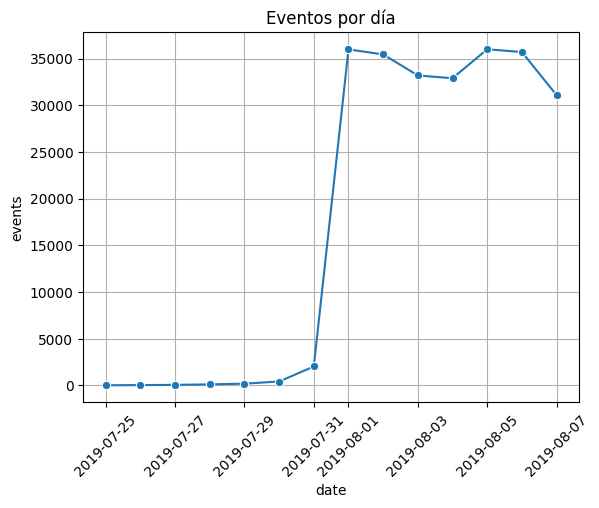

In [ ]:
#Agregar datos
events_by_date = data.groupby('date').agg(events=('event', 'count')).reset_index()

#visualizacion
sns.lineplot(
    data=events_by_date,
    x='date',
    y='events',
    marker= 'o'
)

plt.title('Eventos por día')
plt.xticks(rotation=45)
plt.grid()

plt.show()

In [ ]:
#Eliminar fechas con poca informacion
data = data.query('date >= "2019-08-01"')

**Comportamiento de los eventos por hora**

<function matplotlib.pyplot.show(close=None, block=None)>

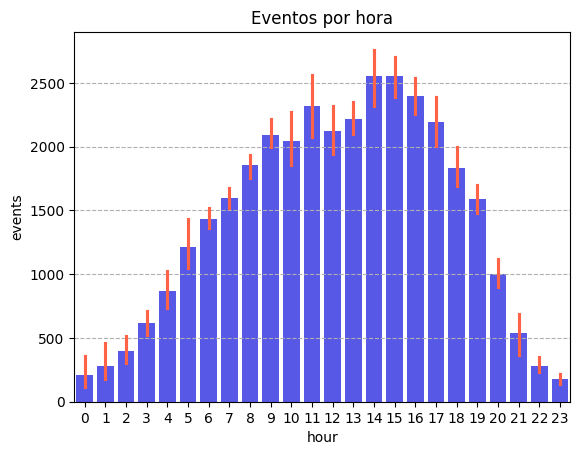

In [ ]:
events_by_hour = data.groupby(['date', 'hour']).agg(events=('event', 'count')).reset_index()

sns.barplot(
    data=events_by_hour,
    x='hour',
    y='events',
    color='blue',
    alpha=0.75,
    err_kws={'color': 'tomato'}
)

plt.grid(axis='y', linestyle='--')
plt.title('Eventos por hora')
plt.show

**Balance de los grupos experimentales**

In [ ]:
events_by_exp = data.groupby('group').agg(events=('event', 'count'))
events_by_exp['share'] = 100*events_by_exp['events'] / events_by_exp['events'].sum()
events_by_exp


,events,share
group,,
A1,79102,32.923637
A2,76804,31.967169
B,84353,35.109195


# Balance por dia


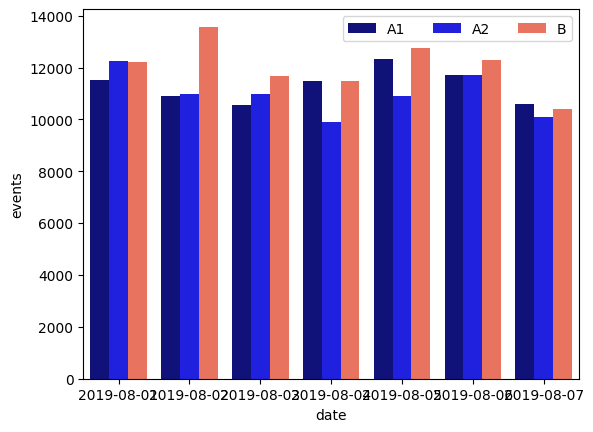

In [ ]:
events_by_dategroup = data.groupby(['date', 'group']).agg(events=('event', 'count')).reset_index()

sns.set_palette(['darkblue','blue', 'tomato'])

sns.barplot(
    data=events_by_dategroup,
    x='date',
    y='events',
    hue='group'
)

plt.legend(title= '', ncol=3)

plt.show()


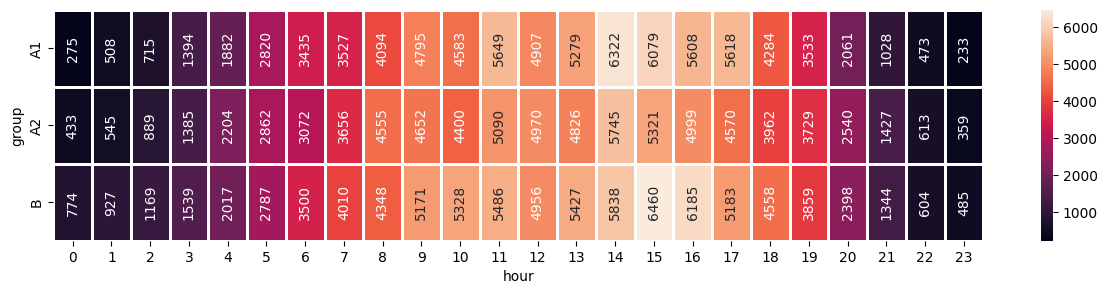

In [ ]:
#balance por hora
events_by_hourgroup = data.pivot_table(
    columns='hour',
    index='group',
    values='event',
    aggfunc='count'
)

plt.subplots (figsize=(15,3))

sns.heatmap(
    data= events_by_hourgroup,
    linewidths=1,
    annot=True,
    fmt='d',
    annot_kws={'rotation': 90}
)

plt.show()

In [ ]:
#Tasa de conversion de grupo A1

funnel_A1 = (
    data.query('group == "A1"')
    .pivot_table(index='event', values='user', aggfunc='nunique')
    .sort_values('user', ascending=False)
)

n_A1 = funnel_A1['user'].max()
funnel_A1['convA1'] = 100*funnel_A1['user'] / n_A1
funnel_A1.drop(columns='user', inplace=True)

print(funnel_A1) 

                             convA1
event                              
MainScreenAppear         100.000000
OffersScreenAppear        62.938776
CartScreenAppear          51.673469
PaymentScreenSuccessful   48.979592


In [ ]:
#Tasa de conversion de grupo A2

funnel_A2 = (
    data.query('group == "A2"')
    .pivot_table(index='event', values='user', aggfunc='nunique')
    .sort_values('user', ascending=False)
)

n_A2 = funnel_A2['user'].max()
funnel_A2['convA1'] = 100*funnel_A2['user'] / n_A2
funnel_A2.drop(columns='user', inplace=True)

print(funnel_A2) 

                             convA1
event                              
MainScreenAppear         100.000000
OffersScreenAppear        61.389338
CartScreenAppear          50.000000
PaymentScreenSuccessful   46.768982


In [ ]:
#Tasa de conversion de grupo B

funnel_B = (
    data.query('group == "B"')
    .pivot_table(index='event', values='user', aggfunc='nunique')
    .sort_values('user', ascending=False)
)

n_B = funnel_B['user'].max()
funnel_B['convA1'] = 100*funnel_B['user'] / n_B
funnel_B.drop(columns='user', inplace=True)

print(funnel_B) 

                             convA1
event                              
MainScreenAppear         100.000000
OffersScreenAppear        61.411953
CartScreenAppear          49.338147
PaymentScreenSuccessful   47.372643


In [ ]:
#funnel agregado

funnel = (
    funnel_A1
    .merge(funnel_A2, on= 'event')
    .merge(funnel_B, on='event')
)

funnel.columns = ['A1', 'A2', 'B']  

print(funnel)

                                 A1          A2           B
event                                                      
MainScreenAppear         100.000000  100.000000  100.000000
OffersScreenAppear        62.938776   61.389338   61.411953
CartScreenAppear          51.673469   50.000000   49.338147
PaymentScreenSuccessful   48.979592   46.768982   47.372643


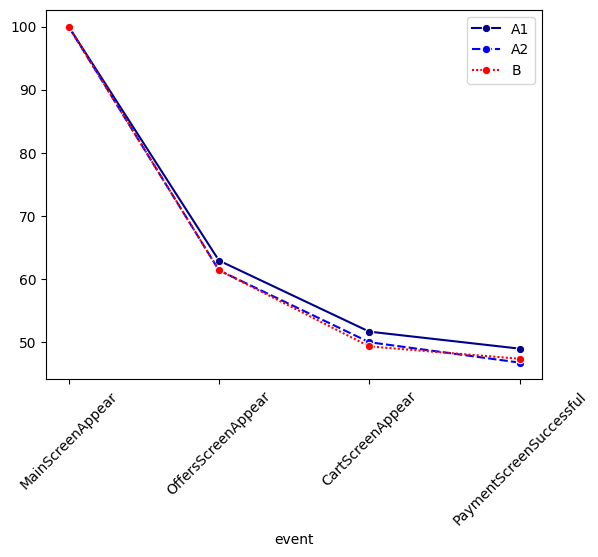

In [ ]:
#Visualizacion de funnel

sns.set_palette(['darkblue', 'blue', 'red'])

sns.lineplot(data=funnel, marker='o')



plt.xticks(rotation=45)
plt.show()

**Pruebas de hipotesis**

- Hipotesis nula: No hay diferencias significativas entre los grupos experimentales
- hipotesis alternativa: Existen diferencias significativas entre los grupos experimentales

In [ ]:
#Tener una serie con el numero de observaciones de cada grupo
n = pd.Series([n_A1, n_A2, n_B], index=['A1', 'A2', 'B'])
n

A1    2450
A2    2476
B     2493
dtype: int64

In [ ]:
# Prueba de hipotesis en el evento offerscreenappear antre A1 y A2

#Significancia
alpha = 0.05

#Exitos de la muestra 1
p_1 = funnel.loc['OffersScreenAppear', 'A1'] /100
suc_1 = int(p_1*n['A1'])
#suc_1

#Exitos de la muestra 2
p_2 = funnel.loc['OffersScreenAppear', 'A2'] /100
suc_2 = int(p_2*n['A2'])
#suc_2

#Consolidar en una lista los existos y observaciones
suc = [suc_1, suc_2]
obs = [n['A1'], n['A2']]

#Prueba de hipotesis
z_stat, p_value = proportions_ztest(
    count=suc,
    nobs=obs,
    alternative='two-sided'
)

print (f'Valor p: {p_value:.1%}')

#Calcular los intervalos de confianza
(inf_1, inf_2), (sup_1, sup_2) = proportion_confint(
    count=suc,
    nobs=obs,
    alpha=alpha
)
print(f'Intervalo de confianza para A1: [{inf_1:.1%}, {sup_1:.1%}]')
print(f'Intervalo de confianza para A2: [{inf_2:.1%}, {sup_2:.1%}]')

#Criterio de decision

if p_value > alpha:
    print('No se rechaza la hipotesis nula: Las tasas de conversion son iguales')
else:
    print('Se rechaza la hipotesis nula: Las tasas de conversion son diferentes')

Valor p: 26.2%
Intervalo de confianza para A1: [61.0%, 64.9%]
Intervalo de confianza para A2: [59.5%, 63.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


In [ ]:
#Funcion secuencial para pruebas de hipotesis
def prueba_ab (evento, g1, g2 , alpha=0.05):
    p_1 = funnel.loc[evento, g1] /100
    suc_1 = int(p_1*n[g1])

    p_2 = funnel.loc[evento, g2] /100
    suc_2 = int(p_2*n[g2])

    suc = [suc_1, suc_2]
    obs = [n[g1], n[g2]]

    z_stat, p_value = proportions_ztest(
        count=suc,
        nobs=obs,
        alternative='two-sided'
    )

    print (f'Valor p: {p_value:.1%}')
    (inf_1, inf_2), (sup_1, sup_2) = proportion_confint(
        count=suc,
        nobs=obs,
        alpha=alpha
    )


    print(f'Intervalo de confianza para {g1}: [{inf_1:.1%}, {sup_1:.1%}]')
    print(f'Intervalo de confianza para {g2}: [{inf_2:.1%}, {sup_2:.1%}]')

    if p_value > alpha:
        print('No se rechaza la hipotesis nula: Las tasas de conversion son iguales')
    else:
        print('Se rechaza la hipotesis nula: Las tasas de conversion son diferentes')
    return p_value

In [ ]:
#Hacer los test para cada evento entro los dintintos grupos

#Comprobacion entre grupos A1 y A2
A1_A2 = []
for e in funnel.index[1:]:
    print(f'EVENTO: {e}')
    print('====================')
    A1_A2.append(prueba_ab(e, 'A1', 'A2'))
    print('\n')
    

EVENTO: OffersScreenAppear
Valor p: 26.2%
Intervalo de confianza para A1: [61.0%, 64.9%]
Intervalo de confianza para A2: [59.5%, 63.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: CartScreenAppear
Valor p: 24.0%
Intervalo de confianza para A1: [49.7%, 53.7%]
Intervalo de confianza para A2: [48.0%, 52.0%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: PaymentScreenSuccessful
Valor p: 12.0%
Intervalo de confianza para A1: [47.0%, 51.0%]
Intervalo de confianza para A2: [44.8%, 48.7%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales




In [ ]:
#Comprobacion entre grupos A1 y b
A1_B = []
for e in funnel.index[1:]:
    print(f'EVENTO: {e}')
    print('====================')
    A1_B.append(prueba_ab(e, 'A1', 'B'))
    print('\n')

EVENTO: OffersScreenAppear
Valor p: 25.6%
Intervalo de confianza para A1: [61.0%, 64.9%]
Intervalo de confianza para B: [59.5%, 63.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: CartScreenAppear
Valor p: 10.1%
Intervalo de confianza para A1: [49.7%, 53.7%]
Intervalo de confianza para B: [47.4%, 51.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: PaymentScreenSuccessful
Valor p: 25.8%
Intervalo de confianza para A1: [47.0%, 51.0%]
Intervalo de confianza para B: [45.4%, 49.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales




In [ ]:
#Comprobacion entre grupos A2 y B
A2_B = []
for e in funnel.index[1:]:
    print(f'EVENTO: {e}')
    print('====================')
    A2_B.append(prueba_ab(e, 'A2', 'B'))
    print('\n')

EVENTO: OffersScreenAppear
Valor p: 99.0%
Intervalo de confianza para A2: [59.5%, 63.3%]
Intervalo de confianza para B: [59.5%, 63.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: CartScreenAppear
Valor p: 64.1%
Intervalo de confianza para A2: [48.0%, 52.0%]
Intervalo de confianza para B: [47.4%, 51.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales


EVENTO: PaymentScreenSuccessful
Valor p: 67.0%
Intervalo de confianza para A2: [44.8%, 48.7%]
Intervalo de confianza para B: [45.4%, 49.3%]
No se rechaza la hipotesis nula: Las tasas de conversion son iguales




In [ ]:
signif = pd.DataFrame(dict(
    A1vsA2 = A1_A2,
    A1vsB = A1_B,
),index = funnel.index[1:])

print(signif)
print('\n')

signif = signif.reset_index().melt(id_vars= 'event', var_name='group', value_name='signif')
print(signif)

                           A1vsA2     A1vsB
event                                      
OffersScreenAppear       0.262234  0.256105
CartScreenAppear         0.240123  0.100610
PaymentScreenSuccessful  0.120443  0.258264


                     event   group    signif
0       OffersScreenAppear  A1vsA2  0.262234
1         CartScreenAppear  A1vsA2  0.240123
2  PaymentScreenSuccessful  A1vsA2  0.120443
3       OffersScreenAppear   A1vsB  0.256105
4         CartScreenAppear   A1vsB  0.100610
5  PaymentScreenSuccessful   A1vsB  0.258264


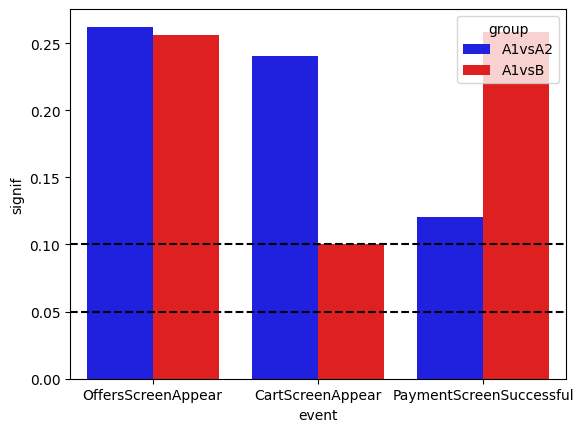

In [ ]:
sns.set_palette([ 'blue', 'red'])

sns.barplot(
    data=signif,
    x='event',
    y='signif',
    hue='group'
)

plt.axhline(y=0.05, color='black', linestyle='--')
plt.axhline(y=0.1, color='black', linestyle='--')

plt.show()